# Emotion Training

In this notebook we are first check whether GPUs in the training environment are available. Then we import the data, split the data into training, validation and test set. We explain the class imbalance problem of the training set and our remedies to overcome this problem. Then we define functions to augment the training set. However, data augmentation is not always applied to see check the differences in performance. Then we preprocess the training and validation set for processing speed on the GPUs. Next we train various models with different strategies. Some models are our own creations, inspired by the literature. Some prepackaged archtitectures are also used. 

For training the model we used the following strategy: 

First we started with our own models to see how they perform on this task. Then we move to transfer learning of more complex and popular archtitectures like ResNet50, Xception and VGGs. Sometimes we make use of finetuning too. Given that we have a quite large training dataset with more than 6000 images per class, we also train some of these more complex architectures from scratch on the GPUs of the Bocconi DSBA server.

Our approach for training the emotion recognition model is based on "try, check the results, try again with different hyperparameters and try something else". We think that this approach is the best, because we cannot state based on a theory which model must be the best for the given task. 

Structure of the training notebook: 

[1. Import of Modules and Data](#1.-Import-of-Modules-and-Data)<br>
[2. Final Preprocessing Steps](#2.-Final-Preprocessing-Steps)<br>
[3. Training Expression Recognition Models](#3.-Training-Expression-Recognition-Models)<br>
[4. Selfmade Models](#4.-Selfmade-Models)<br>
[5. Transfer Learning](#5.-Transfer-Learning)<br>
[6. Keras Models with Transfer Learning](#6.-Keras-Models-with-Transfer-Learning)<br>
[7. Keras Models w/o Transfer Learning](#7.-Keras-Models-w/o-Transfer-Learning)<br>

__Comments on the Results:__ 

Our best model is a slightly adjusted ResNet50 Model trained from scratch which achieves an average weighted precision of roughly 59%. The validation accuracy of our model is about 60%. In our view, our performance is not bad given that we have seven different classes to predict.

Moreover, emotion classification datasets are usually not so clean and the best performing models on Kaggle competitions based only on the FER dataset have about 70% accuracy. We suspect that especially the expression in the wild dataset and the RAF-DB contain images that are very difficult to correctly predict for our models as they are images in an unstaged setting. Thus, many faces don't look directly in the camera and rather show the profile of the person. For a human the emotion is still recognizable, but a neural network may have difficulties in generalizing. Moreover, emotion recognition is an inherently challenging task due to subtle difference in way people are expressing emotions. That makes labeling of large datasets difficult in the first place. 

Most importantly, the emotions we are trying to label are in some cases homogeneous. Of course, a happy face is easily recognized by a big smile. But differentiating between fear, neutral, sad faces can be very subjective and thus it is difficult to generalize these emotions well. 


__Results Location:__

Since we trained many different models, we had to combine several notebooks. The __classification reports and confusion matrices of our models are stored in the emotion_model_csv folder__, which is a subfolder of the expression recognition folder. Inside this notebook we are only showing the results of the models that we did not need to train from the command line. 

The __models__ and the corresponding __weight__ files are stored inside the models_and_weights folder.

## 1. Import of Modules and Data

In [5]:
#Own imports: 
from eval_functions import model_performance, evaluate, save_architecture
import model_modules
import os
import os.path
os.environ['TF_CPP_MIN_LOG_LEVEL']="2" #ignore tf information messages
import sys
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, preprocessing, applications
from tensorflow.keras.models import Sequential, Model,  load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout, Softmax, Flatten,Activation ,BatchNormalization, Input, ReLU 
from tensorflow.keras.layers import SeparableConv2D, Conv2D, ZeroPadding2D, Convolution2D, Activation, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.metrics import Precision, Recall, CategoricalAccuracy, Accuracy
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K
from tensorflow import random
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import pathlib
import cv2
import scipy
from PIL import Image
import sklearn
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, f1_score, classification_report
import time



##################
#####Settings#####
##################


base_folder = "/Users/Felix/datasets/facial_expression_full/"

directory = base_folder + "expression_main/"


##################
#####Settings#####
##################

# Target Image Size: 
IMG_HEIGHT = 96
IMG_WIDTH = 96

# Tensorflow Settings
AUTOTUNE = tf.data.experimental.AUTOTUNE
#batch_size = 32
#batch_size = 64


In [5]:
# make sure that the GPU are correctly identified
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
#import the full label dataset
df_all = pd.read_csv(directory + "/labels/expression_labels.csv", 
                    sep='\t',
                     encoding='utf-8')

In [7]:
df_all.head(5)

,image_name,label
0,amazed_son_192_2.png,1
1,fer0015078.png,2
2,crying_black_659_4.png,3
3,fierce_face_236_0.png,4
4,heartbroken_people_520_0.png,0


In [8]:
df_all.drop(df_all.loc[df_all['image_name'] == ".DS_Store"].index, inplace=True)
df_all.drop(df_all.loc[df_all['label'] == ".DS_Store"].index, inplace=True)

C:\Users\Felix\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Check whether all files are available, such that there are no problems in training the neural network

In [9]:
file_list = df_all["image_name"]
to_delete = []

#collect files that are listed but actually not stored in directory
#some files went missing during grayscale conversion

for file in file_list: 
    if os.path.isfile(directory + 'grayscaled_images/' + file):
        continue
    else:
        to_delete.append(file)

initial_files = len(df_all)
num_missing = len(to_delete)        
     
for i in to_delete: 
    df_all = df_all[df_all["image_name"] != i]

after_del = len(df_all)
assert initial_files - num_missing == after_del

print(len(df_all))

136199


In [10]:
df_all.shape, df_all.dtypes

((136199, 2),
 image_name    object
 label          int64
 dtype: object)

In [13]:
df_all.label = df_all.label.astype('int32')

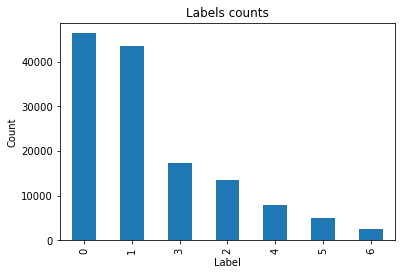

In [14]:
df_all.label.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [15]:
emo_dict = {0:"neutral", 1:"happy", 2:"surprise", 3:"sad", 4:"anger", 5:"disgust", 6:"fear"}

In [16]:
df_all.label.value_counts()

0    46358
1    43442
3    17425
2    13525
4     7947
5     4979
6     2523
Name: label, dtype: int64

Although we deem each class to have a sufficient samples, the dataset is very imbalanced. Class 1 represents the "neutral" emotion label, label 2 represents "happy" pictures and contain by far the largest share of observations. Class 6 represents "disgust" and class 7 represents "fear". Since our final goal is to predict all classes well, with less attention to "fear" given our application, we want to reduce the amount samples such that the data is more balanced overall and that the neural network can **train** on balanced classes. Since the idea of having a validation set is to select the epoch/iteration where the neural network is most likely to perform the best on the test set, we leave the validation and test set untouched. 

#### 2. Final Preprocessing Steps

Create Train, Validation and Test Set

In [17]:
def train_test_val_split(dataset):
    """
    Balanced split to train (60%), test (20%) and val (20%)
    """
    # Split to train and test
    train_df, test_df = train_test_split(dataset, test_size =0.2, random_state=2)
    # Split train to train and validation datasets #0.25*0.8=0.2
    train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=2) 
    return train_df, val_df, test_df

train_df, val_df, test_df = train_test_val_split(df_all)

In [18]:
#observations per class in the training dataset in pct.
train_df.label.value_counts(1)


0    0.340924
1    0.319338
3    0.127816
2    0.099365
4    0.057135
5    0.037250
6    0.018172
Name: label, dtype: float64

We observe that the training set is currently heavily imbalanced. Although the set size itself is large, the ratio of of observations in class 1 to the the observations in class 6 and class 7 exceeds 17:1, respectively. This can be problematic in the sense that the neural network can become precise in predicting the majority classes well, but fails to predict the minority classes. This problem can be "hidden" as the validation and test set have the same imbalance. Thus, the neural network has lots of majority class validation and test samples to perform well on. Hence, overall the accuracy of the neural network is high, but it may be much lower in the minority classes. Therefore, it is important to monitor the prediction performance on each class. 

### Rebalance the training set: 

Class 0 neutral:  34%<br>
Class 1 happy:    32%<br>
Class 3 sad:      12%<br>
Class 2 surprise: 10%<br>
Class 4 anger:    6% <br>
Class 5 disgust:  4% <br>
Class 6 fear:     2% <br>


For deep learning tasks a few thousand pictures per class can be sufficient to train a network to a reasonable accuracy. Given that we also target a transfer learning below, we conclude that we can easily reduce the number of observations in the majority classes and artificially increase the number of samples in the minority classes. The objective is to reduce the majority to minority class observation ratio to 3:1 at most in the first attempts. 

Certainly, quality of data and especially the accuracy in labeling are factors that drive the required input size. However, deep learning is also about trying different approaches and therefore we start by randomly undersampling and oversampling the majority and minority classes to each our target ratios. 

Note: Reducing the majority classes to 9000 observations should leave us with sufficient data for training the model. We increase the classes representing "fear" and "disgust" by a factor of ~2. Fear remains a minority class with 3000 observations. But for our *application* of assessing customer emotions, we hypothesize that fear is the least relevant class. 

After rebelancing, the training set now has the following distribution: 

Class 0 neutral:  16.6%<br>
Class 1 happy:    16.6%<br>
Class 3 sad:      16.6%<br>
Class 2 surprise: 16.6<br>
Class 4 anger:    16.6% <br>
Class 5 disgust:  11.1% <br>
Class 6 fear:     5.55% <br>

In [19]:
#Random over- and undersampling to decrease the ratio of observations between classes

# Count samples per class
class_0 = train_df[train_df['label'] == 0]
class_1 = train_df[train_df['label'] == 1]
class_2 = train_df[train_df['label'] == 2]
class_3 = train_df[train_df['label'] == 3]
class_4 = train_df[train_df['label'] == 4]
class_5 = train_df[train_df['label'] == 5]
class_6 = train_df[train_df['label'] == 6]

# Undersampling class 0, 1, 3
class_0 = class_0.sample(9000) #neutral (1:1 ratio relative to largest class)
class_1 = class_1.sample(9000) #happy (1:1)
class_3 = class_3.sample(9000) #surpise (1:1)

# Oversampling class 3, 5, 6, 7
class_2 = class_2.sample(9000, replace = True) #sad (1:1)
class_4 = class_4.sample(9000, replace = True) #anger (1:1)
class_5 = class_5.sample(6000, replace = True) #disgust (3:2)
class_6 = class_6.sample(3000, replace = True) #fear not that important for application (3:1)

# Merge the training dataframe back together & shuffle it to restore randomness: 
train_df_rs= pd.concat([class_0, class_1, class_2, class_3, class_4, class_5, class_6], axis=0)
train_df_rs= shuffle(train_df_rs)

train_df_rs.head()

,image_name,label
129500,fer0019182.png,4
46289,fer0029757.png,4
16627,boring_woman_250_0.png,5
46791,fer0012549.png,4
62495,fer0000479.png,2


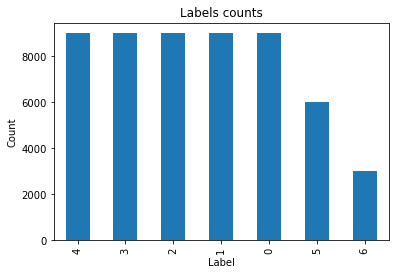

In [20]:
train_df_rs.label.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [21]:
#Create training tensor
images_names_train = train_df_rs['image_name'].values
labels_train= train_df_rs['label'].values
train_ds = tf.data.Dataset.from_tensor_slices((images_names_train, labels_train))

images_names_val = val_df['image_name'].values
labels_val= val_df['label'].values
val_ds = tf.data.Dataset.from_tensor_slices((images_names_val, labels_val))

images_names_test = test_df['image_name'].values
labels_test= test_df['label'].values
test_ds = tf.data.Dataset.from_tensor_slices((images_names_test, labels_test))
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

To increase training speed and improve learning from image data, we standardize the per image, which transforms the pixel values such that their mean is zero and their variance is 1. Finally, we resize the picture to the target size, cast the pixel values to tf.float32 and normalize the pixel values!

In [22]:
def decode_and_resize(image_name, label):
    image = tf.io.read_file(directory + 'grayscaled_images/' + image_name)
    #channels=3 stacks three grayscaled pictures on top of each other
    image = tf.image.decode_png(image, channels=3, dtype="uint8") 
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return tf.cast(image, tf.float32) / 255.0, label 

We try data augmentation for the training dataset to reduce the risk of overfitting. With data augmentation, the model performance on the test set is often better. Our approach to data augmentation for grayscale pictures is based on Appendix B.2 in https://arxiv.org/pdf/1707.09725.pdf. We randomly change brightness, randomly vary the contrast, and randomly flip vertically. 

In [23]:
def augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.5) 
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5) 
    image = tf.image.random_flip_left_right(image, seed=None)
    return image, label

Next, we configure the training and validation dataset for performance by using batch sizes and prefetching of shuffled images. This allows us to augment data on the fly using the CPU and use the full power of the GPU to train the model.

In [24]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel

#Training Dataset
train_ds = train_ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

#Validation Dataset
val_ds = val_ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.shuffle(buffer_size=1000)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [25]:
#Test Dataset
test_ds = test_ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)

In [26]:
expressions = ['neutral','happy', 'surprise', 'sad','anger', 'disgust','fear']

Next, we plot some images of the validation set to check whether to get an impression of our data. 

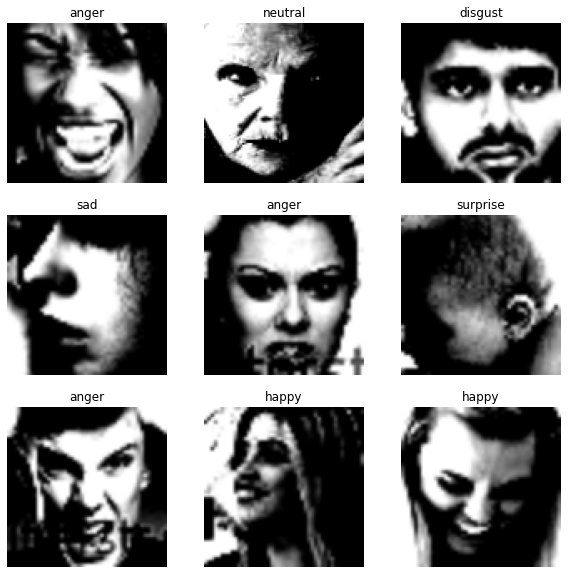

In [35]:
image_batch, label_batch = next(iter(val_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy(),)
    label = label_batch[i]
    plt.title(expressions[label])
    plt.axis("off")

In [37]:
# check that the batching has worked.
len(train_ds), len(val_ds), len(test_ds)

(1688, 852, 852)

# 3. Training Expression Recognition Models

In this section we start with the training of our models. For our multiclass, single-label classification task we use "categorical crossentropy as our loss. Since our labels are of numerical type and not one-hot encoded, we use "sparse categorical crossentropy" as our loss function.

We make use of several callbacks. 

First, we use the ReduceLROnPlateau functionality provided by tensorflow. This function lowers the learning rate when the tracked metric of choice, in our case "val_accuracy" approaches a maximum.

Second, we use EarlyStopping to stop training our models early in case the val_accuracy metric does not improve over 10 epochs.

# 4. Selfmade Models

## VGG inspired models

The next architecture we can explore is one composed of various VGG modules. The VGG network architecture was introduced by Simonyan and Zisserman in their 2014 paper "Very Deep Convolutional Networks for Large Scale Image Recognition" and consisted of usually 3×3 convolutional layers stacked on top of each other and followed by a max pooling layers. Indeed, we will also stack several consecutive convolutional layers followed by a max pooling layer.

In [29]:
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, concatenate, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [33]:
# set early stopper so that it is possible to stop training when the val_accuracy metric has stopped improving
earlystopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

# set ReduceLROnPlateau to reduce learning rate when the val_accuracy metric is increasing slowly
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=2,
                              verbose=1, 
                              mode='max', 
                              min_lr=0.00001)

In [28]:
# import the VGG module
from model_modules import vgg_block, classifier

In particualar, the first architecture of this type we want to try one composed of:
* input layer
* 2 convolutiona layers with 32 filters followed by a max pooling layer
* 2 convolutiona layers with 64 filters followed by a max pooling layer
* 2 convolutiona layers with again 64 filters followed by a max pooling layer
* final dense layer

We decided to increase the number of filters in the convolutional layers as we went deeper with the network so that hopefully the network is able to extract and identify more complex and abstract features than will help in making more accurate predictions.

In [35]:
# set the input layers
inputs = Input(shape=(96,96,3))

# add the first VGG module with 32 filters
VGG_layer = vgg_block(inputs,n_filters=32, n_conv=2)

# add the second VGG module with 64 filters
VGG_layer = vgg_block(VGG_layer,n_filters=64, n_conv=2)

# add the third VGG module with again 64 filters
VGG_layer = vgg_block(VGG_layer,n_filters=64, n_conv=2)

# add the classifier at the bottom
output = classifier(VGG_layer, num_classes=7, activation='softmax')

# create the full model
VGG_model_1 = Model(inputs=inputs, outputs=output)
# VGG_model_1 = Model(inputs=inputs, outputs=VGG_layer)

# check the summary of the model
VGG_model_1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)       

In [36]:
# compile the model
VGG_model_1.compile(loss='sparse_categorical_crossentropy',
                    optimizer = 'rmsprop',
                    metrics = ['accuracy'])

In [46]:
# Save the best model during the traning
# FL stands for full dataset
VGG_model_1_checkpointer = ModelCheckpoint('VGG_model_1_FD.h5', 
                               monitor='val_accuracy', 
                               #verbose=1, 
                               save_best_only=True, 
                               save_weights_only=False)

In [47]:
# training the model
VGG_model_1_history = VGG_model_1.fit(train_ds,
                                        validation_data=val_ds, 
                                        epochs=50, 
                                        batch_size=64,
                                        validation_steps=None, 
                                        callbacks=[earlystopper, VGG_model_1_checkpointer, reduce_lr])

Epoch 1/50
844/844 [==============================] - 290s 344ms/step - loss: 1.3509 - accuracy: 0.4933 - val_loss: 1.7492 - val_accuracy: 0.4543
Epoch 2/50
844/844 [==============================] - 34s 41ms/step - loss: 1.3035 - accuracy: 0.5129 - val_loss: 1.8891 - val_accuracy: 0.4348
Epoch 3/50
844/844 [==============================] - 36s 43ms/step - loss: 1.2716 - accuracy: 0.5271 - val_loss: 1.7530 - val_accuracy: 0.4680
Epoch 4/50
844/844 [==============================] - 36s 42ms/step - loss: 1.2349 - accuracy: 0.5384 - val_loss: 1.8569 - val_accuracy: 0.4621
Epoch 5/50
844/844 [==============================] - 34s 40ms/step - loss: 1.2043 - accuracy: 0.5550 - val_loss: 1.8441 - val_accuracy: 0.4710
Epoch 6/50
844/844 [==============================] - 39s 46ms/step - loss: 1.1687 - accuracy: 0.5690 - val_loss: 2.1643 - val_accuracy: 0.4475
Epoch 7/50
842/844 [============================>.] - ETA: 0s - loss: 1.1352 - accuracy: 0.5837
Epoch 00007: ReduceLROnPlateau reducin

In [31]:
# import functions to evaluate the model
from eval_functions import model_performance, evaluate

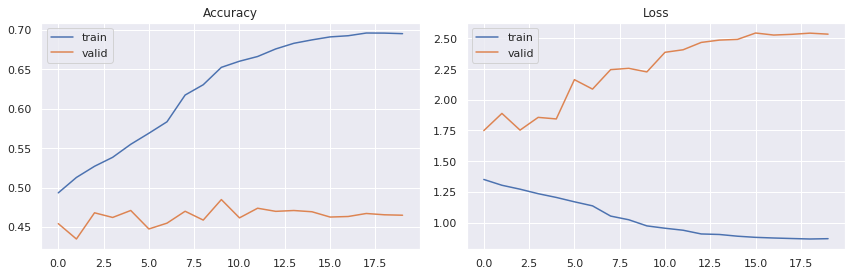

<Figure size 432x288 with 0 Axes>

In [49]:
# plot the accuracy and the loss for both train and validation
model_performance(VGG_model_1_history, model_name = "VGG_model_1")

This first model reaches a training and validation accuracy of around 0.6 and 0.45 respectively. In particular the validation accuracy seems to plateau after the first 10 epoch, suggesting that the model after that is likely to be overfitting. Similarly, as expected, the train loss keeps decreasing as the number of epochs increases while the validation loss is more erratic during the first stages of the training but then stabilizes.

{'neutral': {'precision': 0.604427804004558, 'recall': 0.39370162230940514, 'f1-score': 0.47682034159496595, 'support': 9431}, 'happy': {'precision': 0.7324574068726538, 'recall': 0.5845143449706187, 'f1-score': 0.650176225568728, 'support': 8679}, 'surprise': {'precision': 0.33476119083315486, 'recall': 0.5882574331953331, 'f1-score': 0.42669942669942673, 'support': 2657}, 'sad': {'precision': 0.3007380073800738, 'recall': 0.3767697197341809, 'f1-score': 0.3344876234449147, 'support': 3461}, 'anger': {'precision': 0.23529411764705882, 'recall': 0.48897290485192185, 'f1-score': 0.31770726714431935, 'support': 1587}, 'disgust': {'precision': 0.08900144717800289, 'recall': 0.12961011591148577, 'f1-score': 0.10553410553410554, 'support': 949}, 'fear': {'precision': 0.16872427983539096, 'recall': 0.1722689075630252, 'f1-score': 0.1704781704781705, 'support': 476}, 'accuracy': 0.4638032305433186, 'macro avg': {'precision': 0.35220060767869904, 'recall': 0.3905850069337101, 'f1-score': 0.354

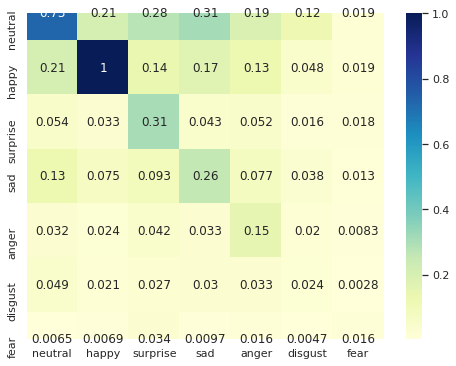

In [50]:
# plot the confusion matrix
report_VGG_model_1 = evaluate(VGG_model_1, model_name = "VGG_model_1", test_ds=test_ds,batch_size=64)

From the confusion matrix above we can see that the model is able to identify all the happy faces. Moreover, it also achieves an excellent score for detecting neutral faces. In constrast the model struggles to identify the emotions of disgust and fear. 

In [51]:
# load the saved model
VGG_model_1_reconstructed = load_model('VGG_model_1_FD.h5')

### Try a deeper VGG model

In order to improve the performance of the previous VGG_inspired model we can try to increase the total number of layers in the model.

In [56]:
# set the input layers
inputs = Input(shape=(96,96,3))

# add the first VGG module with 16 filters
VGG_layer = vgg_block(inputs,n_filters=16, n_conv=2)

# add the second VGG module with 32 filters
VGG_layer = vgg_block(VGG_layer,n_filters=32, n_conv=2)

# add the third VGG module with 64 filters
VGG_layer = vgg_block(VGG_layer,n_filters=64, n_conv=2)

# add the fourth VGG module with 128 filters
VGG_layer = vgg_block(VGG_layer,n_filters=128, n_conv=2)

# add the classifier at the bottom
output = classifier(VGG_layer, num_classes=7, activation='softmax')

# create the full model
VGG_model_2 = Model(inputs=inputs, outputs=output)
# VGG_model_2 = Model(inputs=inputs, outputs=VGG_layer)

# check the summary of the model
VGG_model_2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 96, 16)        448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)       

In [57]:
# set early stopper so that it is possible to stop training when the val_accuracy metric has stopped improving
earlystopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

# set ReduceLROnPlateau to reduce learning rate when the val_accuracy metric is increasing slowly
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=2,
                              verbose=1, 
                              mode='max', 
                              min_lr=0.00001)

In [58]:
# compile the second VGG-inspired model
VGG_model_2.compile(loss='sparse_categorical_crossentropy',
                    optimizer = 'rmsprop',
                    metrics = ['accuracy'])

In [59]:
# Save the best model during the traning
# FL stands for full dataset
VGG_model_2_checkpointer = ModelCheckpoint('VGG_model_2_FD.h5', 
                               monitor='val_accuracy', 
                               #verbose=1, 
                               save_best_only=True, 
                               save_weights_only=False)

In [60]:
# training the second VGG-inspired model
VGG_model_2_history = VGG_model_2.fit(train_ds,
                                        validation_data=val_ds, 
                                        epochs=50, 
                                        batch_size=64,
                                        validation_steps=None, 
                                        callbacks=[earlystopper, VGG_model_2_checkpointer, reduce_lr])

Epoch 1/50
844/844 [==============================] - 491s 582ms/step - loss: 1.9017 - accuracy: 0.1684 - val_loss: 1.8335 - val_accuracy: 0.0988
Epoch 2/50
844/844 [==============================] - 47s 56ms/step - loss: 1.8997 - accuracy: 0.1686 - val_loss: 1.8191 - val_accuracy: 0.0988
Epoch 3/50
844/844 [==============================] - 45s 54ms/step - loss: 1.8992 - accuracy: 0.1683 - val_loss: 1.8115 - val_accuracy: 0.3398
Epoch 4/50
844/844 [==============================] - 41s 49ms/step - loss: 1.8652 - accuracy: 0.2199 - val_loss: 2.1632 - val_accuracy: 0.2722
Epoch 5/50
844/844 [==============================] - 37s 44ms/step - loss: 1.6952 - accuracy: 0.3388 - val_loss: 2.0094 - val_accuracy: 0.3819
Epoch 6/50
844/844 [==============================] - 49s 58ms/step - loss: 1.5304 - accuracy: 0.4146 - val_loss: 1.7270 - val_accuracy: 0.4088
Epoch 7/50
844/844 [==============================] - 47s 56ms/step - loss: 1.4266 - accuracy: 0.4598 - val_loss: 1.6164 - val_accurac

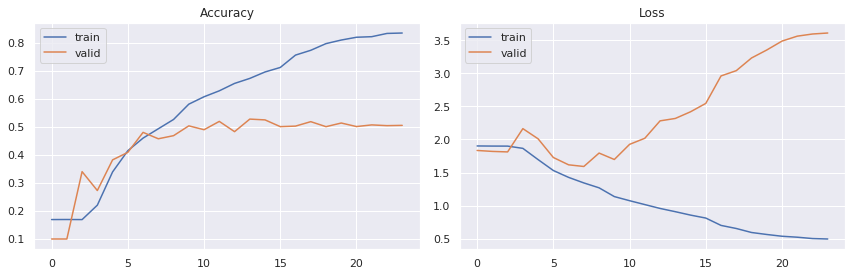

<Figure size 432x288 with 0 Axes>

In [61]:
# get the performance of the model
model_performance(VGG_model_2_history, model_name = "VGG_model_2")

This second VGG-inspired model performs significantly better, reaching an accuracy of above 50% on the validation data. Nonetheless, the plot of the loss suggests that the model started overfitting after the 15th epoch.

{'neutral': {'precision': 0.6016060095842507, 'recall': 0.4925246527409607, 'f1-score': 0.5416277985074627, 'support': 9431}, 'happy': {'precision': 0.757774607703281, 'recall': 0.612052079732688, 'f1-score': 0.6771623430428962, 'support': 8679}, 'surprise': {'precision': 0.3905590717299578, 'recall': 0.5573955589010162, 'f1-score': 0.45929601488602884, 'support': 2657}, 'sad': {'precision': 0.3174529398094353, 'recall': 0.3946836174516036, 'f1-score': 0.35188047398248323, 'support': 3461}, 'anger': {'precision': 0.30467511885895404, 'recall': 0.4845620667926906, 'f1-score': 0.37411821941133544, 'support': 1587}, 'disgust': {'precision': 0.10299488677867057, 'recall': 0.14857744994731295, 'f1-score': 0.12165660051768767, 'support': 949}, 'fear': {'precision': 0.19193857965451055, 'recall': 0.21008403361344538, 'f1-score': 0.20060180541624875, 'support': 476}, 'accuracy': 0.5071218795888399, 'macro avg': {'precision': 0.38100017344558, 'recall': 0.4142684941685311, 'f1-score': 0.3894776

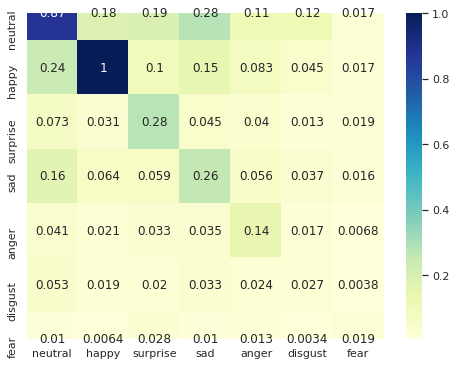

In [62]:
# evaluate the model
report_VGG_model_2 = evaluate(VGG_model_2, model_name = "VGG_model_2", test_ds=test_ds,batch_size=64)

In [64]:
# load the saved model
VGG_model_2_reconstructed = load_model('VGG_model_2_FD.h5')
type(VGG_model_2_reconstructed)

tensorflow.python.keras.engine.functional.Functional

## Inception Module

After having experimented with various configurations of models based on sequential layers it's time to implement architectures of a different nature. In particular we can start including inception modules. The first idea that than would lead to the implementation of the inception module was first introduce by Min Lin, Qiang Chen and Shuicheng Yan in their 2014 paper "Network In Network". This idea was then further developed by Szegedy at al in the 2015 paper "Going Deeper with Convolutions" in which the researchers presented the GoogLeNet architecture. Given that so far out best model is relatively simple, we will start with the simplest form of the inception module (called the naıve version in the paper) and see what results we are able to obtain.

Specifically, the naive inception module consists of 4 parallel layers:
* a 1x1 convolutional layer
* a 3x3 convolutional layer
* a 5x5 convolutional layer
* a 3x3 maxpooling layer

These layers are then concateneted and passed as input to the next layer

In [70]:
K.clear_session()
from model_modules import naive_inception_module

In [71]:
# set the input layers
inputs = Input(shape=(96,96,3))

# create inception block
layer = naive_inception_module(inputs, 32, 32, 32)

# add single conv2d layer
# layer = Conv2D(filters=8, kernel_size=(3,3))(layer)
# layer = Activation('relu')(layer)

# add max pooling
layer = MaxPooling2D(pool_size=(2,2))(layer)

# flatten the output and add a final fully connected layer
layer = Flatten()(layer)
layer = Dense(units=7)(layer)

output = Activation('softmax')(layer)

# create model
naive_inception_model_1 = Model(inputs=inputs, outputs=output)

In [72]:
# compile the second VGG-inspired model
naive_inception_model_1.compile(loss='sparse_categorical_crossentropy',
                                optimizer = 'rmsprop',
                                metrics = ['accuracy'])
                                #metrics = ['categorical_accuracy'])

In [73]:
# Save the best model during the traning
naive_inception_model_1_checkpointer = ModelCheckpoint('naive_inception_model_1_FD.h5', 
                                                       monitor='val_accuracy', 
                                                       #verbose=1, 
                                                       save_best_only=True, 
                                                       save_weights_only=False)

In [74]:
# training the second VGG-inspired model
naive_inception_model_1_history = naive_inception_model_1.fit(train_ds,
                                        validation_data=val_ds, 
                                        epochs=50, 
                                        batch_size=64,
                                        validation_steps=None, 
                                        callbacks=[earlystopper, naive_inception_model_1_checkpointer, reduce_lr])

Epoch 1/50
844/844 [==============================] - 124s 147ms/step - loss: 3.1658 - accuracy: 0.1814 - val_loss: 2.7275 - val_accuracy: 0.3666
Epoch 2/50
844/844 [==============================] - 50s 60ms/step - loss: 2.8206 - accuracy: 0.2054 - val_loss: 2.5735 - val_accuracy: 0.4074
Epoch 3/50
844/844 [==============================] - 47s 56ms/step - loss: 2.7385 - accuracy: 0.2340 - val_loss: 4.2476 - val_accuracy: 0.3048
Epoch 4/50
841/844 [============================>.] - ETA: 0s - loss: 2.7022 - accuracy: 0.2471
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
844/844 [==============================] - 41s 48ms/step - loss: 2.7010 - accuracy: 0.2473 - val_loss: 3.6061 - val_accuracy: 0.3526
Epoch 5/50
844/844 [==============================] - 60s 71ms/step - loss: 1.9172 - accuracy: 0.3075 - val_loss: 3.9031 - val_accuracy: 0.3046
Epoch 6/50
842/844 [============================>.] - ETA: 0s - loss: 1.8903 - accuracy: 0.3183
Epoch 00006: Redu

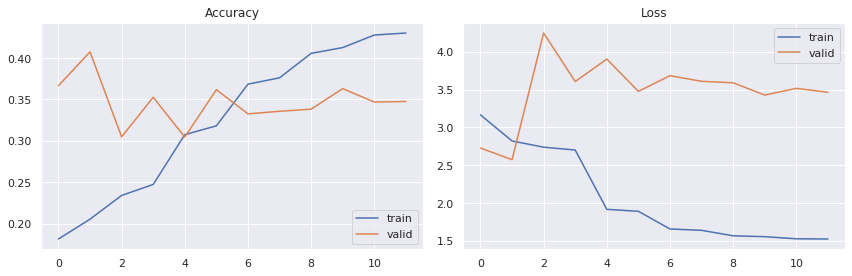

<Figure size 432x288 with 0 Axes>

In [75]:
# get the performance of the model
model_performance(naive_inception_model_1_history, model_name = "naive_inception_model_1")

The simple model containing a naive inception module seems to perform reasonably well given its simplicity. However, it is still far away from the performance of the best VGG-inspired model so far. 

{'neutral': {'precision': 0.5804176072234764, 'recall': 0.21811048669282154, 'f1-score': 0.31707129094412334, 'support': 9431}, 'happy': {'precision': 0.7011223750905141, 'recall': 0.4462495679225717, 'f1-score': 0.5453777370977962, 'support': 8679}, 'surprise': {'precision': 0.24454828660436137, 'recall': 0.5318027850959729, 'f1-score': 0.33503260225251924, 'support': 2657}, 'sad': {'precision': 0.21033610408384532, 'recall': 0.3363189829529038, 'f1-score': 0.258810450250139, 'support': 3461}, 'anger': {'precision': 0.16183324702226826, 'recall': 0.39382482671707625, 'f1-score': 0.22939988988805285, 'support': 1587}, 'disgust': {'precision': 0.06364858807709547, 'recall': 0.14963119072708114, 'f1-score': 0.08930817610062894, 'support': 949}, 'fear': {'precision': 0.11603650586701435, 'recall': 0.1869747899159664, 'f1-score': 0.14320193081255028, 'support': 476}, 'accuracy': 0.3437224669603524, 'macro avg': {'precision': 0.29684895913836795, 'recall': 0.32327323286062765, 'f1-score': 0

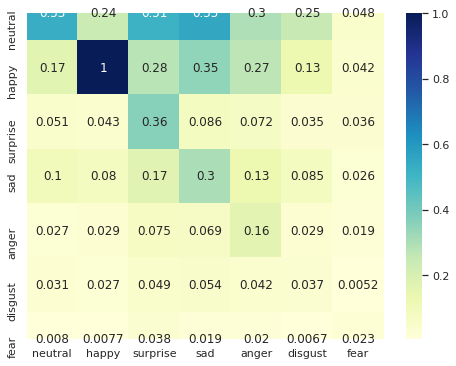

In [76]:
# evaluate the model
report_naive_inception_model_1 = evaluate(naive_inception_model_1, model_name = "naive_inception_model_1", test_ds=test_ds,batch_size=64)

Now we can try to implement the standard inception module. In particular this block takes advantage of dimensionality reduction befor using the 1x1, 3x3 and 5x5 convolutional layers.

## Inception module with dimensionality reduction

Now we can implement the inception module with dimensionality reduction. Specifically, 1x1 convolutions are used to compute reductions before the expensive 3x3 and 5x5 convolutions. Therefore the structure presented above remains essentially the same, the only difference is the addition of 1x1 convolutions before the 3x3 and the 5x5 convolutions. In constrast, a simple 2x3 maxpooling is added before the 1x1 convolution.

In [32]:
K.clear_session()
from model_modules import inception_module

In [78]:
# set the input layers
inputs = Input(shape=(96,96,3))

# create inception block
layer = inception_module(inputs, 64, 64, 64)

# # add single conv2d layer
# layer = Conv2D(filters=8, kernel_size=(3,3))(layer)
# layer = Activation('relu')(layer)

# add max pooling
layer = MaxPooling2D(pool_size=(2,2))(layer)

# flatten the output and add a final fully connected layer
layer = Flatten()(layer)
layer = Dense(units=7)(layer)

output = Activation('softmax')(layer)

# create model
inception_model_1 = Model(inputs=inputs, outputs=output)

# check the summary of the model
inception_model_1.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 96, 96, 64)   256         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 96, 96, 64)   256         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 96, 96, 64)   36928       conv2d_25[0][0]                  
_______________________________________________________________________________________

In [79]:
# inception_model_1.get_weights()

In [80]:
# set early stopper so that it is possible to stop training when the val_accuracy metric has stopped improving
earlystopper_inception_model_1 = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

# set ReduceLROnPlateau to reduce learning rate when the val_accuracy metric is increasing slowly
reduce_lr_inception_model_1 = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=2,
                              verbose=1, 
                              mode='max', 
                              min_lr=0.00001)

In [81]:
# compile the second VGG-inspired model
inception_model_1.compile(loss='sparse_categorical_crossentropy',
                                optimizer = 'rmsprop',
                                metrics = ['accuracy'])

In [82]:
# Save the best model during the traning
inception_model_1_checkpointer = ModelCheckpoint('inception_model_1_FD.h5', 
                                                       monitor='val_accuracy', 
                                                       #verbose=1, 
                                                       save_best_only=True, 
                                                       save_weights_only=False)

In [83]:
# training the second VGG-inspired model
inception_model_1_history = inception_model_1.fit(train_ds,
                                        validation_data=val_ds, 
                                        epochs=50, 
                                        batch_size=64,
                                        validation_steps=None, 
                                        callbacks=[earlystopper_inception_model_1, inception_model_1_checkpointer, reduce_lr_inception_model_1])

Epoch 1/50
  2/844 [..............................] - ETA: 40s - loss: 30.9634 - accuracy: 0.1484

W1128 10:18:15.697967 140266475042624 callbacks.py:328] Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0301s vs `on_train_batch_end` time: 0.0628s). Check your callbacks.


844/844 [==============================] - 276s 327ms/step - loss: 2.3647 - accuracy: 0.2205 - val_loss: 2.3255 - val_accuracy: 0.3142
Epoch 2/50
844/844 [==============================] - 84s 99ms/step - loss: 1.7687 - accuracy: 0.3057 - val_loss: 3.1619 - val_accuracy: 0.3426
Epoch 3/50
844/844 [==============================] - 84s 99ms/step - loss: 1.6982 - accuracy: 0.3442 - val_loss: 3.5650 - val_accuracy: 0.3489
Epoch 4/50
844/844 [==============================] - 84s 100ms/step - loss: 1.6530 - accuracy: 0.3694 - val_loss: 3.6253 - val_accuracy: 0.3361
Epoch 5/50
844/844 [==============================] - ETA: 0s - loss: 1.6191 - accuracy: 0.3842
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
844/844 [==============================] - 85s 101ms/step - loss: 1.6191 - accuracy: 0.3842 - val_loss: 4.7738 - val_accuracy: 0.3206
Epoch 6/50
844/844 [==============================] - 84s 99ms/step - loss: 1.5658 - accuracy: 0.4106 - val_loss: 4.1290 -

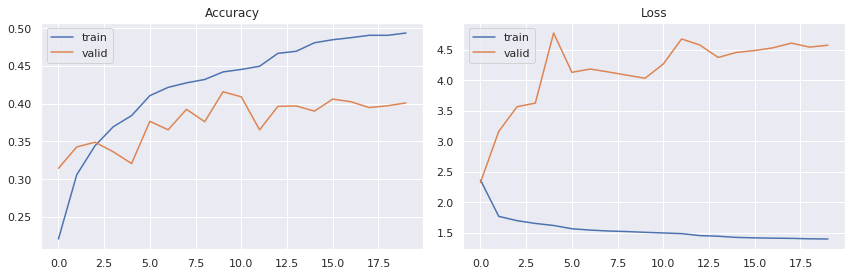

<Figure size 432x288 with 0 Axes>

In [84]:
# get the performance of the model
model_performance(inception_model_1_history, model_name = "inception_model_1")

Even the inception module with dimensionality reduction is not able to match the validation accuracy of the best VGG-model so far. Therefore, as suggested in the paper "Going Deeper with Convolutions" we can try to use Inception modules only at higher layers while keeping
the lower layers in a traditional convolutional fashion.

{'neutral': {'precision': 0.5213920419109392, 'recall': 0.44321917081963735, 'f1-score': 0.479138010087116, 'support': 9431}, 'happy': {'precision': 0.7358642972536349, 'recall': 0.41986403963590274, 'f1-score': 0.5346636343628494, 'support': 8679}, 'surprise': {'precision': 0.31017091622303167, 'recall': 0.4166353029732781, 'f1-score': 0.3556055252168326, 'support': 2657}, 'sad': {'precision': 0.21106748925032717, 'recall': 0.3262062987575845, 'f1-score': 0.25629965947786604, 'support': 3461}, 'anger': {'precision': 0.17102564102564102, 'recall': 0.42028985507246375, 'f1-score': 0.24312010205941315, 'support': 1587}, 'disgust': {'precision': 0.08235294117647059, 'recall': 0.10326659641728135, 'f1-score': 0.09163160355306217, 'support': 949}, 'fear': {'precision': 0.20912547528517111, 'recall': 0.11554621848739496, 'f1-score': 0.14884979702300405, 'support': 476}, 'accuracy': 0.39941262848751835, 'macro avg': {'precision': 0.320142686017888, 'recall': 0.320718211737649, 'f1-score': 0.3

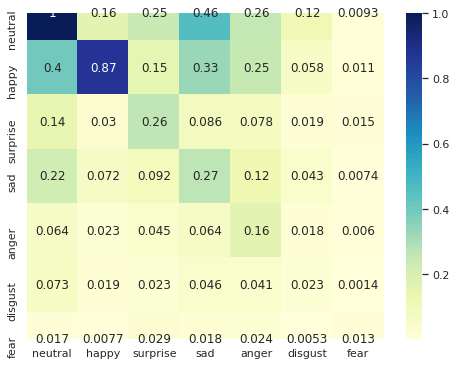

In [85]:
# evaluate the model
report_inception_model_1 = evaluate(inception_model_1, model_name = "inception_model_1", test_ds=test_ds,batch_size=64)

## Combine VGG and Inception module

In [ ]:
K.clear_session()

In [33]:
# set the input layers
inputs = Input(shape=(96,96,3))

# add the first VGG module with 16 filters
VGG_layer = vgg_block(inputs,n_filters=16, n_conv=2)

# add the second VGG module with 32 filters
VGG_layer = vgg_block(VGG_layer,n_filters=32, n_conv=2)

# add the third VGG module with 64 filters
VGG_layer = vgg_block(VGG_layer,n_filters=64, n_conv=2)

# add the fourth VGG module with 128 filters
VGG_layer = vgg_block(VGG_layer,n_filters=128, n_conv=2)

# create inception block
Inception_layer = inception_module(VGG_layer, 64, 64, 64)

# add max pooling
layer = MaxPooling2D(pool_size=(2,2))(Inception_layer)

# flatten the output and add a final fully connected layer
# layer = Flatten()(layer)
# layer = Dense(units=7)(layer)

# output = Activation('softmax')(layer)

# add the classifier at the bottom
output = classifier(layer, num_classes=7, activation='softmax')

# create the full model
VGG_Inception_1 = Model(inputs=inputs, outputs=output)
# VGG_model_2 = Model(inputs=inputs, outputs=VGG_layer)

# check the summary of the model
VGG_Inception_1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 16)   2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 48, 16)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [34]:
# set early stopper so that it is possible to stop training when the val_accuracy metric has stopped improving
earlystopper_VGG_Inception_1 = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

# set ReduceLROnPlateau to reduce learning rate when the val_accuracy metric is increasing slowly
reduce_lr_VGG_Inception_1 = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=2,
                              verbose=1, 
                              mode='max', 
                              min_lr=0.00001)

In [35]:
# compile the second VGG-inspired model
VGG_Inception_1.compile(loss='sparse_categorical_crossentropy',
                                optimizer = 'rmsprop',
                                metrics = ['accuracy'])
                                #metrics = ['categorical_accuracy'])

In [36]:
# Save the best model during the traning
VGG_Inception_1_checkpointer = ModelCheckpoint('VGG_Inception_1_FD.h5', 
                                                       monitor='val_accuracy', 
                                                       #verbose=1, 
                                                       save_best_only=True, 
                                                       save_weights_only=False)

In [37]:
# training the second VGG-inspired model
VGG_Inception_1_history = VGG_Inception_1.fit(train_ds,
                                        validation_data=val_ds, 
                                        epochs=50, 
                                        batch_size=64,
                                        validation_steps=None, 
                                        callbacks=[earlystopper_VGG_Inception_1, VGG_Inception_1_checkpointer, reduce_lr_VGG_Inception_1])

Epoch 1/50
844/844 [==============================] - 637s 755ms/step - loss: 1.9163 - accuracy: 0.1664 - val_loss: 1.8616 - val_accuracy: 0.1070
Epoch 2/50
844/844 [==============================] - 41s 49ms/step - loss: 1.8995 - accuracy: 0.1664 - val_loss: 1.8411 - val_accuracy: 0.1156
Epoch 3/50
844/844 [==============================] - 36s 43ms/step - loss: 1.8981 - accuracy: 0.1747 - val_loss: 1.7743 - val_accuracy: 0.2296
Epoch 4/50
844/844 [==============================] - 40s 47ms/step - loss: 1.8212 - accuracy: 0.2606 - val_loss: 1.8671 - val_accuracy: 0.3635
Epoch 5/50
844/844 [==============================] - 42s 49ms/step - loss: 1.6543 - accuracy: 0.3547 - val_loss: 1.9170 - val_accuracy: 0.3550
Epoch 6/50
844/844 [==============================] - 37s 44ms/step - loss: 1.5115 - accuracy: 0.4174 - val_loss: 1.5928 - val_accuracy: 0.4425
Epoch 7/50
844/844 [==============================] - 39s 46ms/step - loss: 1.4068 - accuracy: 0.4607 - val_loss: 1.3689 - val_accurac

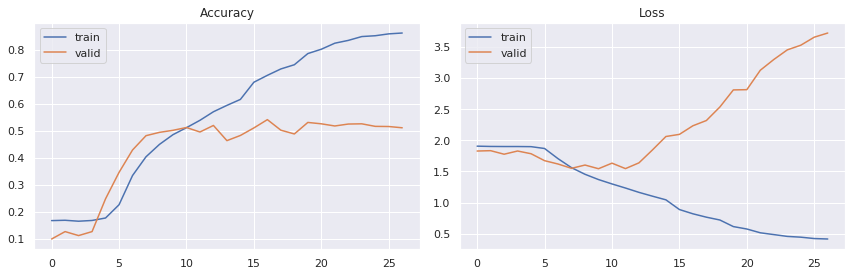

<Figure size 432x288 with 0 Axes>

In [157]:
# get the performance of the model
model_performance(VGG_Inception_1_history, model_name = "VGG_Inception_1")

Unfortunately adding an Inception block to the second VGG model does not seem to be extremely beneficial. Indeed, even though the train accuracy climbs well above 0.8, the validation accuracy does not go far beyond 0.5, which was the previous best performance achieved by the model without the Inception block at the end.
Moreover, looking at the los graph we can see than the validation loss starts decreases but than it rises again after the 11th epoch, suggesting that the model started overfitting.

In [2]:
# evaluate the model
report_inception_model_1 = evaluate(VGG_Inception_1, model_name = "VGG_Inception_1", test_ds=test_ds,batch_size=64)

In [3]:
# load the model
VGG_Inception_1_reconstructed = VGG_Inception_1.load_model('VGG_Inception_1_FD.h5')

# 5. Transfer Learning 

After having tried varioud architectures with both VGG and Inception modules we can try Transfer Learning. In particular, in the next section we will use the ResNet50 architecture trained on the imagenet dataset. In order to be able to use this model we will change the last dense layers to output a probability over 7 classes rather than 1000.

In [ ]:
K.clear_session()

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, concatenate, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96,96,3))

from tensorflow.keras.applications import VGG16
# import the architecture apart from the last dense layer and set the new input shape
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(96,96,3))

# freeze all the layers currently in the model
for layer in base_model_VGG16.layers:
    layer.trainable = False
    
# get the last layer from the base model
x = base_model_VGG16.output

# add maxpooling layer
x = MaxPooling2D(pool_size=(2,2))(x)
# flatten the output
x = Flatten()(x)

# add a intermediate fully-connected layer with 128 units
x = Dense(128, activation='relu')(x)

# add the final dense layer for the 7 classes
predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model_VGG16 = Model(inputs=base_model_VGG16.input, outputs=predictions)
model_VGG16.summary()

In [ ]:
# set early stopper so that it is possible to stop training when the val_accuracy metric has stopped improving
earlystopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

# set ReduceLROnPlateau to reduce learning rate when the val_accuracy metric is increasing slowly
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=2,
                              verbose=1, 
                              mode='max', 
                              min_lr=0.00001)

# compile the model
model_VGG16.compile(loss='sparse_categorical_crossentropy',
                    optimizer = 'rmsprop',
                    metrics = ['accuracy'])
    
# Save the best model during the traning
# FL stands for full dataset
VGG16_model_checkpointer = ModelCheckpoint('VGG16_model_FD.h5', 
                               monitor='val_accuracy', 
                               #verbose=1, 
                               save_best_only=True, 
                               save_weights_only=False)

# training the model
VGG16_model_history = model_VGG16.fit(train_ds,
                                        validation_data=val_ds, 
                                        epochs=20, 
                                        batch_size=64,
                                        validation_steps=None, 
                                        callbacks=[earlystopper, VGG16_model_checkpointer, reduce_lr])

In [ ]:
# get the performance of the model
model_performance(VGG16_model_history, model_name = "model_VGG16_tl")

# evaluate the model
report_model_VGG16 = evaluate(model_VGG16, model_name = "model_VGG16_tl", test_ds=test_ds,batch_size=64)

# 6. Keras Models with Transfer Learning

Next we continue the quest for the best model and try different models with transfer learning and finetuning. Our procedure for each model is the same. First we import the model with 'imagenet' weights from the Keras API and configure it for our task. That is we set the output layer to seven classes and use softmax activation and specify the correct input size. 

In the first step of our training procedure, we freeze all layers but the last one and train the model to convergence. Then the unfreeze the a specific number of last layers. In both the Xception and ResNet50 finetuning, we unfreeze the last two processing blocks. Then we use SGD with a very low learning rate to finetune the model to convergence. 

Both models, Xception and ResNet50 with transfer learning and finetuning, have an average weighted precision in our top 5 of performance. The models converged after 30-40 epochs of training, both for the transfer learning and finetuning part. They reach weighted average precision in the range of 50%-56% on the full test set depending on the model. 

Note: Due to problems with initializing training from the jupyter notebook interface on the DSBA Server, we had to execute these scripts from the command line. This prevents us from showing the training epochs inside this notebook. We have stored all of the prediction results on the test set inside .csv files that we are showing at the end of each model segment. 

# Xception Transfer Learning

In [ ]:
base_model2 = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape= (96, 96, 3),
    classes=7,
    classifier_activation="softmax",
)

# Freeze base model
base_model2.trainable = False

# Define last layers 
inputs = keras.Input(shape=(96, 96, 3))
x = base_model2(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x) #we add an additional dense layer
outputs = keras.layers.Dense(7, activation='softmax')(x)

# add new top layer to base layer
xception_tl = Model(inputs, outputs)
#xception_tl.summary()

xception_tl.compile(
    optimizer = keras.optimizers.RMSprop(),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]) 


earlystopper = EarlyStopping(monitor='val_accuracy', patience=12, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=8,
                                      verbose=1, mode='max', min_lr=0.00001)

# Save the best model during the traning
checkpointer = ModelCheckpoint('xception_20_TL.h5'
                                , monitor='val_accuracy'
                                , verbose=1
                                , save_best_only=True
                               , save_weights_only=False)


save_architecture(xception_tl, "datasets/JSON_models", "xception_tl_model")

#First train the last layer
xception_tl.fit(train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=2,
    callbacks=[earlystopper, checkpointer, reduce_lr]
)

# Setup model for fine tuning
def setup_model(model, trainable):
    # Freeze the un-trainable layers of the model base
    for layer in model.layers[:(len(model.layers) - trainable)]:
        layer.trainable = False

    for layer in model.layers[(len(model.layers) - trainable):]:
        layer.trainable = True

    model.compile(
        loss='sparse_categorical_crossentropy',
        # Slower training rate for fine-tuning
        optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
        metrics=['accuracy']
    )
    
    return model

setup_model(xception_tl, 19)

xception_tl_ft = xception_tl

save_architecture(xception_tl_ft, "datasets/JSON_models", "xception_tl_ft_model")

xception_tl_hist = xception_tl.fit(train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=2,
   callbacks=[earlystopper, checkpointer]
)

In [ ]:
#evaluate(xception_tl ,model_name = "xception_TL")
#model_performance(xcept_tl_hist, model_name = "xception_TL")

The classification report which contains all the metrics can be found in the emotion_model_csv folder: xception_TL_metrics2.csv

# ResNet50 Transfer Learning

In [39]:
base_model3 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    pooling='avg'
)


# Freeze base model
base_model3.trainable = False

# 
inputs = keras.Input(shape=(96, 96, 3))
x = base_model3(inputs, training=False)
outputs = keras.layers.Dense(7, activation='softmax')(x)

# add new top layer to base layer
resnet_50_tl = Model(inputs, outputs)
resnet_50_tl.summary()

resnet_50_tl.compile(
    optimizer = keras.optimizers.RMSprop(),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]) 


earlystopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                                      verbose=1, mode='max', min_lr=0.00001)

# Save the best model during the traning
checkpointer = ModelCheckpoint('resnetTL-{epoch:02d}-{val_accuracy:.2f}.hdf5'
                                , monitor='val_accuracy'
                                , verbose=1
                                , save_best_only=False 
                                , save_weights_only=False)

#First we train the last layer until convergence
resnet_50_tl.fit(train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=2,
    callbacks=[earlystopper, checkpointer_TL ] #note without reduce lr
)


# Setup model for fine tuning
def setup_model(model, trainable):
    # Freeze the un-trainable layers of the model base
    for layer in model.layers[:(len(model.layers) - trainable)]:
        layer.trainable = False

    for layer in model.layers[(len(model.layers) - trainable):]:
        layer.trainable = True

    model.compile(
        loss='sparse_categorical_crossentropy',
        # Slower training rate for fine-tuning
        optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
        metrics=['accuracy']
    )

checkpointer_TL = ModelCheckpoint('nopre-resnetTL_FT-{epoch:02d}-{val_accuracy:.2f}.hdf5'
                                , monitor='val_accuracy'
                                , verbose=1
                                , save_best_only=False 
                                , save_weights_only=False)


#For finetuning the model we unfreeze the last 12 layers     
setup_model(resnet_50_tl, 12)

#resnet_50_tl_fthist = resnet_50_tl.fit(train_ds,
#    validation_data=val_ds,
#    epochs=50,
#    verbose=2,
#    callbacks=[earlystopper, checkpointer_TL ] #note without reduce lr
#)

In [ ]:
K.clear_session()

The classification report which contains all the metrics can be found in the emotion_model_csv folder: resnet_50_tl_metrics.csv

# 7. Keras Models w/o Transfer Learning

In this section we train slightly adjusted Keras Models. First we import the full model and adjust it for our input shape, such that the model can train without problems. We experimented with different epochs and the learning rates on the server, but achieved the best results with the implementations down below.  

# ResNet 50

In [ ]:
resnet_50_model = tf.keras.applications.ResNet50(
    include_top=True,
    input_shape=(96, 96, 3),
    classes=7,
    classifier_activation="softmax"
)


earlystopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10,
                                      verbose=1, mode='max', min_lr=0.00001)

# Save the best model during the traning
checkpointer = ModelCheckpoint('resnet_50_75e.h5'
                                , monitor='val_accuracy'
                                , verbose=1
                                , save_best_only=True 
                                , save_weights_only=True)

resnet_50_model.compile(
  optimizer='RMSprop',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
  )

#resnet_50_model_hist = resnet_50_model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=75,
#    verbose = 1,
#    callbacks=[earlystopper, checkpointer, reduce_lr]
#)


#evaluate(resnet_50  ,model_name = "resnet_50")
#model_performance(resnet_50_hist , model_name = "resnet_50")

The classification report which contains all the metrics can be found in the emotion_model_csv folder: resnet_50_metrics.csv

# ResNet152v2

In [ ]:
K.clear_session()

In [ ]:
resnet152V2 = tf.keras.applications.ResNet152V2(
    include_top=True,
    input_shape=(96, 96, 3),
    classes=7,
    classifier_activation="softmax"
)

#Predition:
#resnet152V2.load_weights(weight_dir_pred + 'resnet152V2.h5', skip_mismatch=True, by_name=True)


earlystopper = EarlyStopping(monitor='val_accuracy', patience=12, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=8,
                                      verbose=1, mode='max', min_lr=0.00001)

# Save the best model during the traning
checkpointer = ModelCheckpoint('resnet152V2.h5'
                                , monitor='val_accuracy'
                                , verbose=1
                                , save_best_only=True
                                , save_weights_only=False)

resnet152V2.compile(
  optimizer='RMSprop',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
  )

#save_architecture(resnet152V2, "datasets/JSON_models", "resnet152V2_model")

#resnet152V2_hist = resnet152V2.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=60,
#    verbose = 1,
#    callbacks=[earlystopper, checkpointer, reduce_lr]
#)

#evaluate(resnet152V2,model_name = "resnet152V2")
#model_performance(resnet152V2_hist , model_name = "resnet152V2")

The classification report which contains all the metrics can be found in the emotion_model_csv folder: resnet152V2_metrics.csv

# Xception

In [ ]:
K.clear_session()

In [ ]:
xception_model = tf.keras.applications.Xception(
    include_top=True,
    input_shape= (96, 96, 3),
    classes=7,
    classifier_activation="softmax",
)

earlystopper = EarlyStopping(monitor='val_accuracy', patience=12, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=8,
                                      verbose=1, mode='max', min_lr=0.00001)

# Save the best model during the traning
checkpointer = ModelCheckpoint('xception_35evaluation.h5'
                                , monitor='val_accuracy'
                                , verbose=1
                                , save_best_only=True
                                , save_weights_only=False)

xception_model.compile(
  optimizer='RMSprop',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
  )

save_architecture(xception_model, "datasets/JSON_models", "xception_model")

In [ ]:
#xception_hist = xception_model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=50,
#    verbose=2,
#    callbacks=[earlystopper, checkpointer, reduce_lr]
#)

In [ ]:
#evaluate(xception_model ,model_name = "xception")
#model_performance(xception_hist, model_name = "xception")

The classification report which contains all the metrics can be found in the emotion_model_csv folder: xception_metrics.csv